In [164]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from copy import copy
from sklearn.preprocessing import StandardScaler

In [8]:
traindf = pd.read_csv('alananer/datasets/observations_train.csv')
testdf = pd.read_csv('alananer/datasets/observations_test.csv')

In [10]:
traindf['date']=pd.to_datetime(traindf["date"])
testdf['date']=pd.to_datetime(testdf["date"])

Missing data in training set 

In [11]:
df_train = pd.DataFrame()
week_train = pd.DataFrame()
monthly_train = pd.DataFrame()
daily_train_m = pd.DataFrame()
for col in np.unique(traindf['series_id']):
    temp = traindf[traindf['series_id']==col].set_index('date')
    SP500 = traindf[traindf['series_id']=='SP500'].set_index('date')
    idx = pd.date_range(min(np.unique(SP500.index)), max(np.unique(SP500.index)))
    temp.index = pd.DatetimeIndex(temp.index)
    temp = temp.reindex(idx, fill_value=None)
    temp['series_id']=col
    temp['value'] = temp['value'].interpolate(method='time')
    df_train = df_train.append(temp)

In [12]:
from collections import Counter
total = np.unique(df_train['series_id'])
res = np.unique(df_train[df_train['value'].isnull()]['series_id'])
use_feat = list((Counter(total)-Counter(res)-Counter(['SP500'])).elements())

In [13]:
X_train = df_train[df_train['series_id'].isin(use_feat)]
X_train = X_train.pivot(columns='series_id')

X_train.columns = X_train.columns.droplevel(0)
X_train.reset_index(drop=True, inplace=True)
Y_train = df_train[df_train['series_id']=='SP500']
Y_train = Y_train.pivot(columns='series_id')
Y_train.columns = Y_train.columns.droplevel(0)
Y_train.reset_index(drop=True, inplace=True)

In [15]:
X_train.shape

(2511, 20)

In [17]:
X_train_bestfeat = X_train[['BAA10Y','DEXCHUS','DEXUSEU']]

In [18]:
X_train_bestfeat

series_id,BAA10Y,DEXCHUS,DEXUSEU
0,2.5300,6.596500,1.3474
1,2.5300,6.588400,1.3494
2,2.5300,6.588400,1.3547
3,2.5600,6.585000,1.3612
4,2.5800,6.573100,1.3673
...,...,...,...
2506,1.7825,6.550925,1.1860
2507,1.7800,6.542900,1.1867
2508,1.7600,6.556000,1.1902
2509,1.7600,6.532200,1.1952


In [167]:
pd.options.mode.chained_assignment = None  # default='warn'

continuous_cols = ['BAA10Y','DEXCHUS','DEXUSEU']
features = X_train_bestfeat[continuous_cols]
scaler = StandardScaler().fit(features.values)
X_train_bestfeat[continuous_cols] = scaler.transform(features.values)

In [168]:
X_train_bestfeat

series_id,BAA10Y,DEXCHUS,DEXUSEU
0,-0.428796,0.868595,0.917411
1,-0.428796,0.834370,0.934243
2,-0.428796,0.834370,0.978846
3,-0.355216,0.820004,1.033547
4,-0.306163,0.769723,1.084883
...,...,...,...
2506,-2.262164,0.676026,-0.440876
2507,-2.268296,0.642118,-0.434985
2508,-2.317349,0.697470,-0.405530
2509,-2.317349,0.596907,-0.363452


In [169]:
rf =  RandomForestRegressor()
params = [{'n_estimators':[200],'max_features':[1,2,3],}]
tscv = TimeSeriesSplit(n_splits=30)
clf = GridSearchCV(rf, params, cv=tscv, scoring=['r2','neg_root_mean_squared_error'], refit=False, verbose=0)

In [170]:
rf_model = clf.fit(X_train_bestfeat,Y_train.values.ravel())

In [171]:
pr2 = rf_model.cv_results_['params'][ np.argmin(rf_model.cv_results_['rank_test_r2'])]
prmse = rf_model.cv_results_['params'][ np.argmin(rf_model.cv_results_['rank_test_neg_root_mean_squared_error'])]

In [172]:
rf.set_params(**pr2)
rf.fit(X_train_bestfeat,Y_train.values.ravel())

train_r2_predictions = rf.predict(X_train_bestfeat)

In [173]:
rf.set_params(**prmse)
rf.fit(X_train_bestfeat,Y_train.values.ravel())

train_rmse_predictions = rf.predict(X_train_bestfeat)

In [174]:
r2_score(Y_train,train_r2_predictions)

0.999572174820794

In [175]:
mean_squared_error(Y_train,train_rmse_predictions,squared=False)

7.462398704603708

In [53]:
r2_data = {'True':Y_train.values.ravel(), 'Predicted':train_r2_predictions}
r2_df = pd.DataFrame(data=r2_data)

In [55]:
rmse_data = {'True':Y_train.values.ravel(), 'Predicted':train_rmse_predictions}
rmse_df = pd.DataFrame(data=rmse_data)

In [56]:
r2_df.to_csv('r2_data')

In [57]:
rmse_df.to_csv('rmse_data')

In [108]:
X_train

series_id,AAA10Y,BAA10Y,DEXCHUS,DEXUSEU,DEXUSUK,DFII10,DFII20,DFII30,DFII5,DFII7,DLTIIT,DPCREDIT,DPRIME,EFFR,INFECTDISEMVTRACKD,IOER,IORR,T10YIE,TEDRATE,WLEMUINDXD
0,1.5900,2.5300,6.596500,1.3474,1.60230,1.3400,1.910,2.1800,0.5100,1.06,1.9800,0.75,3.25,0.15,0.59,0.25,0.25,2.28,0.180,30.44
1,1.6500,2.5300,6.588400,1.3494,1.61280,1.3300,1.910,2.1700,0.4400,1.00,1.9700,0.75,3.25,0.16,0.45,0.25,0.25,2.28,0.180,23.19
2,1.6500,2.5300,6.588400,1.3547,1.60630,1.3700,1.950,2.2100,0.4300,1.01,1.9900,0.75,3.25,0.15,0.34,0.25,0.25,2.25,0.190,45.74
3,1.6800,2.5600,6.585000,1.3612,1.61720,1.3100,1.900,2.1900,0.3300,0.92,1.9500,0.75,3.25,0.15,0.87,0.25,0.25,2.27,0.220,14.88
4,1.7000,2.5800,6.573100,1.3673,1.62450,1.2500,1.860,2.1600,0.2600,0.87,1.9100,0.75,3.25,0.15,0.00,0.25,0.25,2.34,0.210,12.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,1.0625,1.7825,6.550925,1.1860,1.33715,0.5325,0.705,0.8325,0.4775,0.51,0.7425,2.00,4.50,1.42,0.00,1.50,1.50,1.94,0.314,20.56
2507,1.0600,1.7800,6.542900,1.1867,1.33690,0.5300,0.700,0.8300,0.4900,0.51,0.7400,2.00,4.50,1.42,0.00,1.50,1.50,1.94,0.292,41.35
2508,1.0500,1.7600,6.556000,1.1902,1.34030,0.4800,0.640,0.7600,0.4000,0.47,0.6800,2.00,4.50,1.42,0.41,1.50,1.50,1.94,0.270,13.95
2509,1.0500,1.7600,6.532200,1.1952,1.34500,0.4700,0.640,0.7500,0.3700,0.43,0.6700,2.00,4.50,1.42,0.00,1.50,1.50,1.96,0.320,12.77


In [111]:
training_data = X_train.copy()

In [112]:
training_data['SP500'] = Y_train

In [113]:
training_data

series_id,AAA10Y,BAA10Y,DEXCHUS,DEXUSEU,DEXUSUK,DFII10,DFII20,DFII30,DFII5,DFII7,...,DPCREDIT,DPRIME,EFFR,INFECTDISEMVTRACKD,IOER,IORR,T10YIE,TEDRATE,WLEMUINDXD,SP500
0,1.5900,2.5300,6.596500,1.3474,1.60230,1.3400,1.910,2.1800,0.5100,1.06,...,0.75,3.25,0.15,0.59,0.25,0.25,2.28,0.180,30.44,1332.32
1,1.6500,2.5300,6.588400,1.3494,1.61280,1.3300,1.910,2.1700,0.4400,1.00,...,0.75,3.25,0.16,0.45,0.25,0.25,2.28,0.180,23.19,1328.01
2,1.6500,2.5300,6.588400,1.3547,1.60630,1.3700,1.950,2.2100,0.4300,1.01,...,0.75,3.25,0.15,0.34,0.25,0.25,2.25,0.190,45.74,1336.32
3,1.6800,2.5600,6.585000,1.3612,1.61720,1.3100,1.900,2.1900,0.3300,0.92,...,0.75,3.25,0.15,0.87,0.25,0.25,2.27,0.220,14.88,1340.43
4,1.7000,2.5800,6.573100,1.3673,1.62450,1.2500,1.860,2.1600,0.2600,0.87,...,0.75,3.25,0.15,0.00,0.25,0.25,2.34,0.210,12.48,1343.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,1.0625,1.7825,6.550925,1.1860,1.33715,0.5325,0.705,0.8325,0.4775,0.51,...,2.00,4.50,1.42,0.00,1.50,1.50,1.94,0.314,20.56,2681.21
2507,1.0600,1.7800,6.542900,1.1867,1.33690,0.5300,0.700,0.8300,0.4900,0.51,...,2.00,4.50,1.42,0.00,1.50,1.50,1.94,0.292,41.35,2680.50
2508,1.0500,1.7600,6.556000,1.1902,1.34030,0.4800,0.640,0.7600,0.4000,0.47,...,2.00,4.50,1.42,0.41,1.50,1.50,1.94,0.270,13.95,2682.62
2509,1.0500,1.7600,6.532200,1.1952,1.34500,0.4700,0.640,0.7500,0.3700,0.43,...,2.00,4.50,1.42,0.00,1.50,1.50,1.96,0.320,12.77,2687.54


In [139]:
training_data.to_csv('training_data')

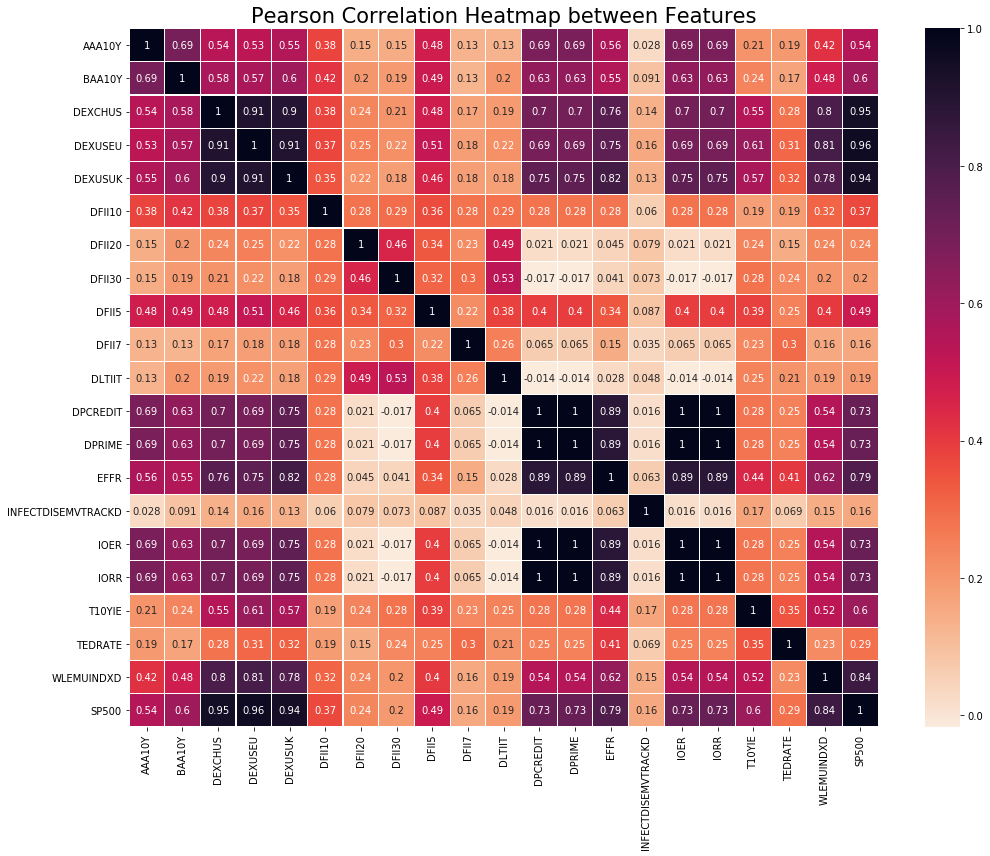

In [140]:
pearson_corr = training_data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson')
plt.figure(figsize = (15,12))
sns.heatmap(pearson_corr, annot = True, linewidths=.15, cmap = "rocket_r")
plt.xlabel(None)
plt.ylabel(None)
plt.title('Pearson Correlation Heatmap between Features', fontsize=21)
plt.tight_layout()

In [137]:
X_train_bestfeat.to_csv('best_features')

In [151]:
testdf

,series_id,date,value
0,AAA10Y,2018-01-02,1.06
1,AAA10Y,2018-01-03,1.06
2,AAA10Y,2018-01-04,1.01
3,AAA10Y,2018-01-05,1.03
4,AAA10Y,2018-01-08,1.01
...,...,...,...
24037,WLEMUINDXD,2020-06-10,103.19
24038,WLEMUINDXD,2020-06-11,299.56
24039,WLEMUINDXD,2020-06-12,254.72
24040,WLEMUINDXD,2020-06-13,169.16


In [246]:
march = pd.read_csv('march6.csv')
march['date']=pd.to_datetime(march["date"])
march.drop(march.columns[0],axis=1,inplace=True)


In [247]:
march["series_id"] = march["series_id"].astype('str')

In [248]:
march.head()

,series_id,date,value
0,AAA10Y,2020-02-28,1.57
1,AAA10Y,2020-03-02,1.51
2,AAA10Y,2020-03-03,1.58
3,AAA10Y,2020-03-04,1.53
4,AAA10Y,2020-03-05,1.60


In [249]:
march_test = pd.DataFrame()
week_test_march = pd.DataFrame()
monthly_test_march = pd.DataFrame()
daily_test_march = pd.DataFrame()
for col in np.unique(march['series_id']):
    temp = march[march['series_id']==col].set_index('date')
    SP500 = march[march['series_id']=='SP500'].set_index('date')
    idx = pd.date_range(min(np.unique(SP500.index)), max(np.unique(SP500.index)))
    temp.index = pd.DatetimeIndex(temp.index)
    temp = temp.reindex(idx, fill_value=None)
    temp['series_id']=col
    temp['value'] = temp['value'].interpolate(method='time')
    march_test = march_test.append(temp)

In [250]:
total = np.unique(march_test['series_id'])
res = np.unique(march_test[march_test['value'].isnull()]['series_id'])
use_feat = list((Counter(total)-Counter(res)-Counter(['SP500'])).elements())

In [251]:
X_march = march_test[march_test['series_id'].isin(use_feat)]
X_march = X_march.pivot(columns='series_id')

X_march.columns = X_march.columns.droplevel(0)
X_march.reset_index(drop=True, inplace=True)
Y_march = march_test[march_test['series_id']=='SP500']
Y_march = Y_march.pivot(columns='series_id')
Y_march.columns = Y_march.columns.droplevel(0)
Y_march.reset_index(drop=True, inplace=True)

In [252]:
X_march = X_march[['BAA10Y','DEXCHUS','DEXUSEU']]

pd.options.mode.chained_assignment = None  # default='warn'

continuous_cols = ['BAA10Y','DEXCHUS','DEXUSEU']
features = X_march[continuous_cols]
scaler = StandardScaler().fit(features.values)
X_march[continuous_cols] = scaler.transform(features.values)

X_march.dropna(axis='columns', inplace = True)
Y_march.dropna(axis='columns', inplace = True)

rf.fit(X_march,Y_march.values.ravel())
march_week_pred = rf.predict(X_march)

In [254]:
march_week_pred

array([2974.1409    , 2998.84938333, 3044.04171667, 3070.21611667,
       3032.23456667, 3096.07031667, 3039.82976667])

In [253]:
march6_week_pred = march_week_pred[6]

IndexError: index 7 is out of bounds for axis 0 with size 7

In [185]:
jan = pd.read_csv('jan_week.csv')
jan['date']=pd.to_datetime(jan["date"])

In [186]:
jan_test = pd.DataFrame()
week_test_jan = pd.DataFrame()
monthly_test_jan = pd.DataFrame()
daily_test_jan = pd.DataFrame()
for col in np.unique(jan['series_id']):
    temp = jan[jan['series_id']==col].set_index('date')
    SP500 = jan[jan['series_id']=='SP500'].set_index('date')
    idx = pd.date_range(min(np.unique(SP500.index)), max(np.unique(SP500.index)))
    temp.index = pd.DatetimeIndex(temp.index)
    temp = temp.reindex(idx, fill_value=None)
    temp['series_id']=col
    temp['value'] = temp['value'].interpolate(method='time')
    jan_test = jan_test.append(temp)

In [187]:
total = np.unique(jan_test['series_id'])
res = np.unique(jan_test[jan_test['value'].isnull()]['series_id'])
use_feat = list((Counter(total)-Counter(res)-Counter(['SP500'])).elements())

In [188]:
X_jan = jan_test[jan_test['series_id'].isin(use_feat)]
X_jan = X_jan.pivot(columns='series_id')

X_jan.columns = X_jan.columns.droplevel(0)
X_jan.reset_index(drop=True, inplace=True)
Y_jan = jan_test[jan_test['series_id']=='SP500']
Y_jan = Y_jan.pivot(columns='series_id')
Y_jan.columns = Y_jan.columns.droplevel(0)
Y_jan.reset_index(drop=True, inplace=True)

In [198]:
X_jan = X_jan[['BAA10Y','DEXCHUS','DEXUSEU']]

pd.options.mode.chained_assignment = None  # default='warn'

continuous_cols = ['BAA10Y','DEXCHUS','DEXUSEU']
features = X_jan[continuous_cols]
scaler = StandardScaler().fit(features.values)
X_jan[continuous_cols] = scaler.transform(features.values)

X_jan.dropna(axis='columns', inplace = True)
Y_jan.dropna(axis='columns', inplace = True)

rf.fit(X_jan,Y_jan.values.ravel())
jan_week_pred = rf.predict(X_jan)

In [201]:
jan10_week_pred = jan_week_pred[7]

In [203]:
july = pd.read_csv('july_week.csv')
july['date']=pd.to_datetime(july["date"])

In [204]:
july_test = pd.DataFrame()
week_test_july = pd.DataFrame()
monthly_test_july = pd.DataFrame()
daily_test_july = pd.DataFrame()
for col in np.unique(july['series_id']):
    temp = july[july['series_id']==col].set_index('date')
    SP500 = july[july['series_id']=='SP500'].set_index('date')
    idx = pd.date_range(min(np.unique(SP500.index)), max(np.unique(SP500.index)))
    temp.index = pd.DatetimeIndex(temp.index)
    temp = temp.reindex(idx, fill_value=None)
    temp['series_id']=col
    temp['value'] = temp['value'].interpolate(method='time')
    july_test = july_test.append(temp)

In [205]:
total = np.unique(july_test['series_id'])
res = np.unique(july_test[july_test['value'].isnull()]['series_id'])
use_feat = list((Counter(total)-Counter(res)-Counter(['SP500'])).elements())

In [206]:
X_july = july_test[july_test['series_id'].isin(use_feat)]
X_july = X_july.pivot(columns='series_id')

X_july.columns = X_july.columns.droplevel(0)
X_july.reset_index(drop=True, inplace=True)
Y_july = july_test[july_test['series_id']=='SP500']
Y_july = Y_july.pivot(columns='series_id')
Y_july.columns = Y_july.columns.droplevel(0)
Y_july.reset_index(drop=True, inplace=True)

In [208]:
X_july = X_july[['BAA10Y','DEXCHUS','DEXUSEU']]

pd.options.mode.chained_assignment = None  # default='warn'

continuous_cols = ['BAA10Y','DEXCHUS','DEXUSEU']
features = X_july[continuous_cols]
scaler = StandardScaler().fit(features.values)
X_july[continuous_cols] = scaler.transform(features.values)

X_july.dropna(axis='columns', inplace = True)
Y_july.dropna(axis='columns', inplace = True)

rf.fit(X_july,Y_july.values.ravel())
july_week_pred = rf.predict(X_july)

In [209]:
july12_week_pred = july_week_pred[7]

In [220]:
march6_year_pred = march_year_pred[365]

2992.094325000004

In [227]:
Y_march

series_id,SP500
0,2798.29
1,2801.31
2,2800.35
3,2799.39
4,2798.43
...,...
361,2975.95
362,2979.63
363,2993.07
364,2999.91
